<a href="https://colab.research.google.com/github/David-Huson/CAP4601_Project2/blob/main/project02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CAP4601-Intro to AI Project 2
## Image Classification using Convolutional Neural Networks

### Install and Import Project Dependencies

In [28]:
%pip install -q tensorflow-datasets
%pip install -U keras-tuner

Note: you may need to restart the kernel to use updated packages.
  Using cached keras_tuner-1.3.4-py3-none-any.whl (172 kB)
  Using cached keras_tuner-1.3.3-py3-none-any.whl (172 kB)
  Using cached keras_tuner-1.3.2-py3-none-any.whl (172 kB)
  Using cached keras_tuner-1.3.1-py3-none-any.whl (172 kB)
  Using cached keras_tuner-1.3.0-py3-none-any.whl (167 kB)
  Using cached keras_tuner-1.2.1-py3-none-any.whl (169 kB)
  Using cached keras_tuner-1.2.0-py3-none-any.whl (168 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt           # used to plot the graphs for the experiments
import numpy as np                        # used to format data into a matrix

import tensorflow as tf                   # used to evaluate and work with models
import tensorflow_datasets as tfds        # used to import datasets from tf

from tensorflow import keras              # used to build the network layers

from keras_tuner import RandomSearch      # used for hyper tuning

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import ipywidgets as widgets 
import json

In [3]:
tfds.disable_progress_bar()             #keep the noteboook clean

### Prepare Data for the network

In [4]:
# tfds.list_builders()
dataset = 'horses_or_humans'
builder = tfds.builder(dataset)
info = builder.info

ds_train = tfds.load(
    name=dataset,
    split='train',
    batch_size=-1,
    as_supervised=True)

ds_test = tfds.load(
    name=dataset,
    split='test',
    batch_size=-1,
    as_supervised=True)

classes = info.features['label'].num_classes

train_images, train_labels = tfds.as_numpy(ds_train)

num_training_samples = len(train_images)

test_images, test_labels = tfds.as_numpy(ds_test)

num_test_samples = len(test_images)


Metal device set to: Apple M2


2023-04-12 13:49:35.170349: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [5]:
train_images = train_images.astype('float32')
train_images /= 255

test_images = test_images.astype('float32')
test_images /= 255

## Load the best model we found

In [6]:
model = keras.models.load_model('./models/best_model')
load_status = model.load_weights("./models/ckpt")

### Evaluate the model with the test data

In [7]:
loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Accuracy: {accuracy*100:.2f}% ")

8/8 [==============================] - 1s 66ms/step - loss: 0.5421 - accuracy: 0.9180
Accuracy: 91.80% 


### See if it can make a correct prediction

#### Choose a random image from the test dataset

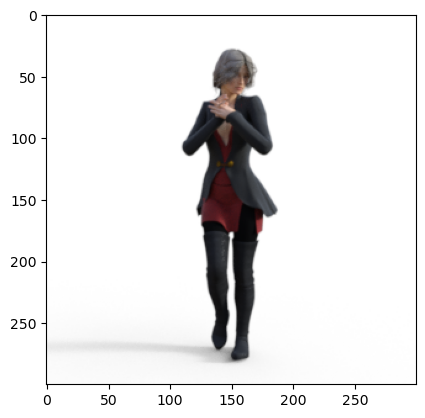

In [8]:
test_image = np.array([test_images[np.random.randint(0, 100+1)]])
rgb_images = np.array(test_image)
rgb_image = rgb_images[0]
plt.imshow(rgb_image)

In [60]:
result = model.predict(test_image)
predicted_value = np.argmax(result)

print(("horse" if predicted_value == 0 else "human") + f" - Confidence:{result[0][predicted_value]*100: .2f}%")

1/1 [==============================] - 0s 11ms/step
human - Confidence: 56.18%


In [34]:

uploader = widgets.FileUpload(
    accept= 'image/*',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False  # True to accept multiple files upload else False
)
display(uploader)

FileUpload(value=(), accept='image/*', description='Upload')

In [76]:
image_bytes = uploader.value[0].content.tobytes()

In [77]:
widgets.Image(value=image_bytes)


Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00\x01\x00\x01\x00\x00\xff\xe1\x14\x17Exif\x00\x00…

In [78]:
import io
from PIL import Image
im = Image.open(io.BytesIO(image_bytes))
image = np.array(im)
image = image.astype('float32')
image /= 255
# print(image.shape)
print()
# image.resize(1, 976, 976, 3)

image_shape = (1,) + image.shape
image = image.reshape(image_shape)
result = model.predict(image)
predicted_value = np.argmax(result)

print(("horse" if predicted_value == 0 else "human") + f" - Confidence:{result[0][predicted_value]*100: .2f}%")


1/1 [==============================] - 0s 13ms/step
horse - Confidence: 53.65%


### Build a [very] Basic Convolutional Neural Network

In [ ]:
model = keras.Sequential([
  keras.layers.Conv2D(64, 3, activation='relu'),
  keras.layers.Conv2D(32, 3, activation='relu'),
  keras.layers.Flatten(),
  keras.layers.Dense(2, activation='softmax')
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(train_images, train_labels, batch_size=32, epochs=10)

#### Evaulate the Model using test data

In [ ]:
loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Accuracy: {accuracy*100:.2f}% ")

In [ ]:
test_image = np.array([test_images[np.random.randint(0, 100+1)]])
rgb_images = np.array(test_image)
rgb_image = rgb_images[0]
plt.imshow(rgb_image)

In [ ]:
result = model.predict(test_image)
predicted_value = np.argmax(result)

print("horse" if predicted_value == 0 else "human")


### A more comprehensive CNN

#### Adding Pooling Layers after each convolution

In [ ]:
model = keras.Sequential([
  keras.layers.Conv2D(64, 3, activation='relu'),
  keras.layers.MaxPool2D(2,2),
  keras.layers.Conv2D(32, 3, activation='relu'),
  keras.layers.MaxPool2D(2,2),
  keras.layers.Flatten(),
  keras.layers.Dense(2, activation='softmax')
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_images, train_labels, batch_size=32, epochs=10)

In [ ]:
loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Accuracy: {accuracy*100:.2f}% ")

#### Adding Dropout

In [ ]:
model = keras.Sequential([
  keras.layers.Conv2D(64, 3, activation='relu'),
  keras.layers.MaxPool2D(2,2),
  keras.layers.Conv2D(32, 3, activation='relu'),
  keras.layers.MaxPool2D(2,2),
  keras.layers.Dropout(0.5),
  keras.layers.Flatten(),
  keras.layers.Dense(2, activation='softmax')
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_images, train_labels, batch_size=32, epochs=10)

In [ ]:
loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Accuracy: {accuracy*100:.2f}% ")

#### Adding an intermediate Dense layer after the flattening

In [ ]:
model = keras.Sequential([
  keras.layers.Conv2D(32, 3, activation='relu'),
  keras.layers.MaxPool2D(2,2),
  keras.layers.Conv2D(32, 3, activation='relu'),
  keras.layers.MaxPool2D(2,2),
  keras.layers.Dropout(0.5),
  keras.layers.Flatten(),
  keras.layers.Dense(64, activation='relu'),
  keras.layers.Dense(2, activation='softmax')
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_images, train_labels, batch_size=32, epochs=10)

In [ ]:
loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Accuracy: {accuracy*100:.2f}% ")

### Hyperparameter Tuning using the Keras Tuner

#### Experimentation With The Number of Convolutional Layers And Their Size

In [ ]:
def build_model(hp):

  model = keras.Sequential()

  for i in range(hp.Int("Conv2D layers", min_value=1, max_value=4)):
    model.add(keras.layers.Conv2D(hp.Choice(f"layer {i} filters", [16, 32, 64]), 3, activation="relu"))

  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(2, activation="softmax"))

  model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  return model

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

tuner = RandomSearch(
                    build_model, 
                    objective="val_accuracy",
                    max_trials=32, 
                     
                    directory='./convLayers',
                    project_name='convLayerTests')
tuner.search(train_images, train_labels, validation_data=(test_images, test_labels), epochs=10, batch_size=32, callbacks=[stop_early])


In [ ]:
tuner.results_summary()
best_model = tuner.get_best_models()[0]

In [ ]:
loss, accuracy = best_model.evaluate(test_images, test_labels)
print(f"Accuracy: {accuracy*100:.2f}%, Loss: {loss:.2f}")

### Experimenting with the kernel size

In [ ]:
def build_model(hp):
  model = keras.Sequential()

  model.add(keras.layers.Conv2D(32, hp.Int("Kernel size", min_value=2, max_value=6), activation="relu"))

  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(2, activation="softmax"))

  model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  return model

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)


In [288]:
kernel_size_tuner = RandomSearch(
                    build_model, 
                    objective="val_accuracy",
                    max_trials=6, 
                    directory='./convLayers',
                    project_name='kernelSizeTests')

In [ ]:
kernel_size_tuner.search(train_images, train_labels, validation_data=(test_images, test_labels), epochs=10, batch_size=32, callbacks=[stop_early])

In [289]:
kernel_size_tuner.results_summary()

Results summary
Results in ./convLayers/kernelSizeTests
Showing 10 best trials
Trial summary
Hyperparameters:
Kernel size: 3
Score: 0.9140625
Trial summary
Hyperparameters:
Kernel size: 2
Score: 0.8515625
Trial summary
Hyperparameters:
Kernel size: 6
Score: 0.8359375
Trial summary
Hyperparameters:
Kernel size: 5
Score: 0.79296875
Trial summary
Hyperparameters:
Kernel size: 4
Score: 0.71484375


#### Results graph

In [290]:
params = kernel_size_tuner.get_best_hyperparameters(num_trials=6) #get hyper params best to worst

scores = []
kernel_size = []
for i in range (5):
    with open(f"./convLayers/kernelSizeTests/trial_{i}/trial.json", 'r') as json_file:
        data = json.load(json_file)
        scores.append(data["score"])
    kernel_size.append(params[i]['Kernel size'])


scores = sorted(scores)
kernel_size = kernel_size[::-1] # reverse the order of the hyperparameters without sorting the list

sortedPairs = sorted(list(zip(scores, kernel_size)), key=lambda x: x[0])
print(sortedPairs)

[(0.71484375, 4), (0.79296875, 5), (0.8359375, 6), (0.8515625, 2), (0.9140625, 3)]


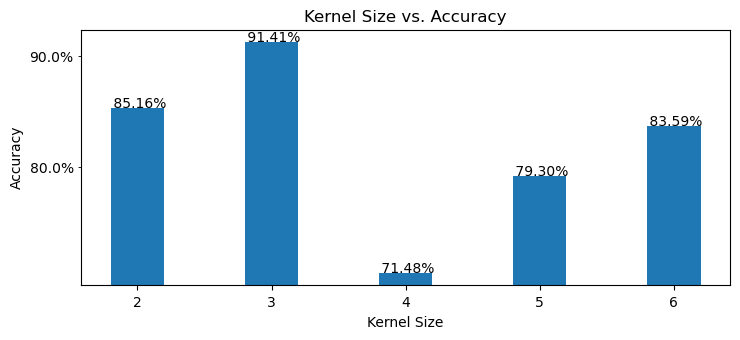

In [294]:
accuracies = [x[0] for x in sortedPairs]
kernel_sizes = [x[1] for x in sortedPairs]

for i in range(len(kernel_sizes)):
    plt.annotate(f"{accuracies[i]*100: .2f}%", xy=(kernel_sizes[i], accuracies[i]), xytext=(kernel_sizes[i], accuracies[i]), ha='center')

plt.yscale("log")
ax = plt.subplot()
ax.yaxis.set_minor_formatter(ticker.PercentFormatter(xmax=1))
plt.title("Kernel Size vs. Accuracy")
plt.xlabel('Kernel Size')
plt.ylabel('Accuracy')
plt.bar(kernel_sizes, accuracies, width=0.4)
plt.savefig('graphs/kernelSize.png')
plt.show()

### Max Pooling Experiments
Experiment to find the best cofiguration of pooling kernel size and stride

In [ ]:
def build_model(hp):
  
  model = keras.Sequential()

  model.add(keras.layers.Conv2D(32, 4))
  model.add(keras.layers.MaxPool2D(hp.Int("Kernel Size", min_value=2, max_value=6), hp.Int("Kernel Stride", min_value=1, max_value=3)))

  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(2, activation="softmax"))

  model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  return model

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

tuner = RandomSearch(
                    build_model, 
                    objective="val_accuracy",
                    max_trials=10, 
                     
                    directory='./convLayers',
                    project_name='maxPoolKernelTests')
tuner.search(train_images, train_labels, validation_data=(test_images, test_labels), epochs=10, batch_size=32, callbacks=[stop_early])

In [ ]:
tuner.results_summary()
best_model = tuner.get_best_models()[0]


### Experimenting with the configuration of convolutions and pooling

In [ ]:
def build_model(hp):
  model = keras.Sequential()

  for i in range(hp.Int("Convolution Layers", min_value=1, max_value=4)):
    model.add(keras.layers.Conv2D(hp.Choice(f"layer {i} filters", [16, 32, 64]), 3, activation="relu"))
    kernelSize = hp.Int("Kernel Size", min_value=0, max_value=6)
    if(kernelSize > 1):
      model.add(keras.layers.MaxPool2D(kernelSize, hp.Int("Kernel Stride", min_value=1, max_value=3)))

  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(2, activation="softmax"))

  model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  return model

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

tuner = RandomSearch(
                    build_model, 
                    objective="val_accuracy",
                    max_trials=10, 
                     
                    directory='./convLayers',
                    project_name='convolutionModuleTests')
tuner.search(train_images, train_labels, validation_data=(test_images, test_labels), epochs=10, batch_size=32, callbacks=[stop_early])

### Experimenting with the number of layers, number of filters per layer, number of max pooling layers, kernel size, and kernel stride

In [ ]:
def build_model(hp):
  model = keras.Sequential()

  for i in range(hp.Int("Convolution Layers", min_value=1, max_value=4)):
    model.add(keras.layers.Conv2D(hp.Choice(f"layer {i} filters", [16, 32, 64]), 3, activation=hp.Choice(f"layer {i} activation", ["relu", "tanh", "softmax"])))
    kernelSize = hp.Int("Kernel Size", min_value=0, max_value=6)
    if(kernelSize > 1):
      model.add(keras.layers.MaxPool2D(kernelSize, hp.Int("Kernel Stride", min_value=1, max_value=3)))

  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(2, activation="softmax"))

  model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  return model

In [ ]:
tuner = RandomSearch(
                    build_model, 
                    objective="val_accuracy",
                    max_trials=100, 
                    directory='./convLayers',
                    project_name='convolutionModuleTestsWithActivation')

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

tuner.search(train_images, train_labels, validation_data=(test_images, test_labels), epochs=10, batch_size=32, callbacks=[stop_early])

In [23]:
tuner = RandomSearch(
                    build_model, 
                    objective="val_accuracy",
                    max_trials=100, 
                    directory='./convLayers',
                    overwrite=False,
                    project_name='convolutionModuleTestsWithActivation')
print(tuner.results_summary())
best_model = tuner.get_best_models()[0]

Results summary
Results in ./convLayers/convolutionModuleTestsWithActivation
Showing 10 best trials
Trial summary
Hyperparameters:
Convolution Layers: 4
layer 0 filters: 64
layer 0 activation: softmax
Kernel Size: 4
layer 1 filters: 16
layer 1 activation: softmax
layer 2 filters: 32
layer 2 activation: tanh
layer 3 filters: 16
layer 3 activation: tanh
Kernel Stride: 3
Score: 0.91796875
Trial summary
Hyperparameters:
Convolution Layers: 3
layer 0 filters: 64
layer 0 activation: softmax
Kernel Size: 2
layer 1 filters: 32
layer 1 activation: relu
layer 2 filters: 32
layer 2 activation: tanh
layer 3 filters: 16
layer 3 activation: tanh
Kernel Stride: 3
Score: 0.9140625
Trial summary
Hyperparameters:
Convolution Layers: 3
layer 0 filters: 32
layer 0 activation: tanh
Kernel Size: 2
layer 1 filters: 16
layer 1 activation: tanh
layer 2 filters: 64
layer 2 activation: softmax
layer 3 filters: 64
layer 3 activation: softmax
Kernel Stride: 2
Score: 0.90625
Trial summary
Hyperparameters:
Convoluti

### Experimenting with the number of Conv2D layers with the same number of filters

In [104]:
def build_model(hp):
  model = keras.Sequential()

  for i in range(hp.Int("Conv2D layers", min_value=1, max_value=6)):
    model.add(keras.layers.Conv2D(32, 3, activation="relu"))

  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(2, activation="softmax"))

  model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  return model

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [295]:
num_trials = 32
conv2d_layers_tuner = RandomSearch(
                    build_model, 
                    objective="val_accuracy",
                    max_trials=num_trials, 
                    directory='./convLayers',
                    project_name='convLayerTests-number-of-layers')


In [106]:
conv2d_layers_tuner.search(train_images, train_labels, validation_data=(test_images, test_labels), epochs=10, batch_size=32, callbacks=[stop_early])

Trial 6 Complete [00h 00m 14s]
val_accuracy: 0.87109375

Best val_accuracy So Far: 0.8828125
Total elapsed time: 00h 07m 32s


In [296]:
print(conv2d_layers_tuner.results_summary())

Results summary
Results in ./convLayers/convLayerTests-number-of-layers
Showing 10 best trials
Trial summary
Hyperparameters:
Conv2D layers: 6
Score: 0.8828125
Trial summary
Hyperparameters:
Conv2D layers: 4
Score: 0.875
Trial summary
Hyperparameters:
Conv2D layers: 1
Score: 0.87109375
Trial summary
Hyperparameters:
Conv2D layers: 5
Score: 0.83984375
Trial summary
Hyperparameters:
Conv2D layers: 2
Score: 0.83203125
Trial summary
Hyperparameters:
Conv2D layers: 3
Score: 0.78515625
None


#### Results graph

In [297]:
num_completed_trials = 6
params = conv2d_layers_tuner.get_best_hyperparameters(num_trials=num_completed_trials) #get hyper params best to worst

scores = []
layers_count = []
for i in range (num_completed_trials):
    with open(f"./convLayers/convLayerTests-number-of-layers/trial_{i:02d}/trial.json", 'r') as json_file:
        data = json.load(json_file)
        scores.append(data["score"])
    layers_count.append(params[i]['Conv2D layers'])

scores = sorted(scores)
layers_count = layers_count[::-1] # reverse the order of the hyperparameters without sorting the list

sortedPairs = sorted(list(zip(scores, layers_count)), key=lambda x: x[0])
print(sortedPairs)

[(0.78515625, 3), (0.83203125, 2), (0.83984375, 5), (0.87109375, 1), (0.875, 4), (0.8828125, 6)]


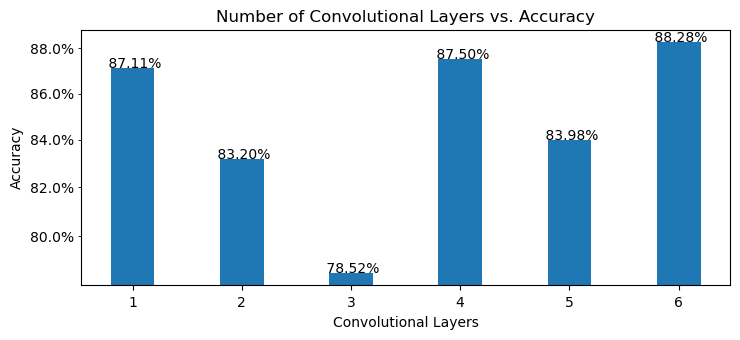

In [299]:
accuracies = [x[0] for x in sortedPairs]
layers_count = [x[1] for x in sortedPairs]

for i in range(len(layers_count)):
    plt.annotate(f"{accuracies[i]*100: .2f}%", xy=(layers_count[i], accuracies[i]), xytext=(layers_count[i], accuracies[i]), ha='center')

plt.yscale("log")
ax = plt.subplot()
ax.yaxis.set_minor_formatter(ticker.PercentFormatter(xmax=1))
plt.title("Number of Convolutional Layers vs. Accuracy")
plt.xlabel('Convolutional Layers')
plt.ylabel('Accuracy')
plt.bar(layers_count, accuracies, width=0.4)
plt.savefig('graphs/numFilters.png')
plt.show()

### Experimenting with only the number of filters in each Convolution

In [87]:
def build_model(hp):
  model = keras.Sequential()

  filterNum = hp.Choice("NumFilters", [16, 32, 64, 128])
  model.add(keras.layers.Conv2D(filterNum, 3, activation="relu"))
  model.add(keras.layers.Conv2D(filterNum, 3, activation="relu"))
  model.add(keras.layers.Conv2D(filterNum, 3, activation="relu"))
  model.add(keras.layers.Conv2D(filterNum, 3, activation="relu"))
  model.add(keras.layers.Conv2D(filterNum, 3, activation="relu"))
  model.add(keras.layers.Conv2D(filterNum, 3, activation="relu"))

  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(2, activation="softmax"))

  model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  return model

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [272]:
num_filters_tuner = RandomSearch(
                    build_model, 
                    objective="val_accuracy",
                    max_trials=32, 
                    directory='./convLayers',
                    project_name='convLayerTests-FilterSize')

In [89]:
num_filters_tuner.search(train_images, train_labels, validation_data=(test_images, test_labels), epochs=10, batch_size=32, callbacks=[stop_early])

Trial 4 Complete [00h 01m 34s]
val_accuracy: 0.91015625

Best val_accuracy So Far: 0.91015625
Total elapsed time: 00h 29m 01s


In [273]:
print(num_filters_tuner.results_summary())

Results summary
Results in ./convLayers/convLayerTests-FilterSize
Showing 10 best trials
Trial summary
Hyperparameters:
NumFilters: 32
Score: 0.91015625
Trial summary
Hyperparameters:
NumFilters: 128
Score: 0.8671875
Trial summary
Hyperparameters:
NumFilters: 16
Score: 0.85546875
Trial summary
Hyperparameters:
NumFilters: 64
Score: 0.8046875
None


#### Results graph

In [274]:
params = num_filters_tuner.get_best_hyperparameters(num_trials=4) #get hyper params best to worst

scores = []
filter_count = []
for i in range(4):
    with open(f"./convLayers/convLayerTests-FilterSize/trial_{i:02d}/trial.json", 'r') as json_file:
        data = json.load(json_file)
        scores.append(data["score"])
    filter_count.append(params[i]['NumFilters'])


scores = sorted(scores)
filter_count = filter_count[::-1] # reverse the order of the hyperparameters without sorting the list

sortedPairs = sorted(list(zip(scores, filter_count)), key=lambda x: x[0])
print(sortedPairs)

[(0.8046875, 64), (0.85546875, 16), (0.8671875, 128), (0.91015625, 32)]


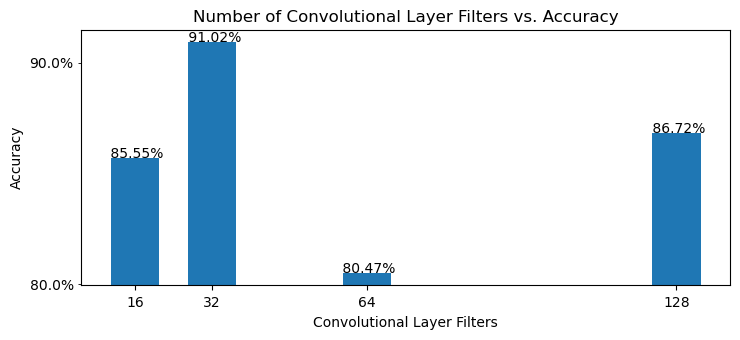

In [275]:
accuracies = [x[0] for x in sortedPairs]
filter_count = [x[1] for x in sortedPairs]

for i in range(len(filter_count)):
    plt.annotate(f"{accuracies[i]*100: .2f}%", xy=(filter_count[i], accuracies[i]), xytext=(filter_count[i], accuracies[i]), ha='center')
plt.yscale("log")
ax = plt.subplot()
ax.yaxis.set_minor_formatter(ticker.PercentFormatter(xmax=1))
plt.xticks(filter_count)
plt.title("Number of Convolutional Layer Filters vs. Accuracy")
plt.xlabel('Convolutional Layer Filters')
plt.ylabel('Accuracy')
plt.bar(filter_count, accuracies, width=10)
plt.show()

### Experimenting with the pool kernel size

In [262]:
def build_model(hp):
  model = keras.Sequential()

  stride = 2
  poolSize = hp.Int("Pooling Kernel Size", min_value=2, max_value=8) 

  model.add(keras.layers.Conv2D(32, 3, activation="relu"))
  model.add(keras.layers.MaxPool2D(poolSize,stride))
  model.add(keras.layers.Conv2D(32, 3, activation="relu"))
  model.add(keras.layers.MaxPool2D(poolSize,stride))
  model.add(keras.layers.Conv2D(32, 3, activation="relu"))
  model.add(keras.layers.MaxPool2D(poolSize,stride))

  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(2, activation="softmax"))

  model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  return model

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [300]:
pooling_kernel_size_tuner = RandomSearch(
                    build_model, 
                    objective="val_accuracy",
                    max_trials=20, 
                    directory='./convLayers',
                    project_name='poolingLayerTests_kernelSize')

In [267]:
pooling_kernel_size_tuner.search(train_images, train_labels, validation_data=(test_images, test_labels), epochs=10, batch_size=32, callbacks=[stop_early])

Trial 7 Complete [00h 01m 24s]
val_accuracy: 0.85546875

Best val_accuracy So Far: 0.85546875
Total elapsed time: 00h 05m 44s


In [301]:
print(pooling_kernel_size_tuner.results_summary())

Results summary
Results in ./convLayers/poolingLayerTests_kernelSize
Showing 10 best trials
Trial summary
Hyperparameters:
Pooling Kernel Size: 6
Score: 0.85546875
Trial summary
Hyperparameters:
Pooling Kernel Size: 8
Score: 0.8515625
Trial summary
Hyperparameters:
Pooling Kernel Size: 2
Score: 0.84765625
Trial summary
Hyperparameters:
Pooling Kernel Size: 3
Score: 0.8359375
Trial summary
Hyperparameters:
Pooling Kernel Size: 7
Score: 0.83203125
Trial summary
Hyperparameters:
Pooling Kernel Size: 4
Score: 0.81640625
Trial summary
Hyperparameters:
Pooling Kernel Size: 5
Score: 0.79296875
None


#### Results Graph

In [302]:
numTrials = 7
params = pooling_kernel_size_tuner.get_best_hyperparameters(num_trials=numTrials) #get hyper params best to worst

scores = []
pool_size = []
for i in range(numTrials):
    with open(f"./convLayers/poolingLayerTests_kernelSize/trial_{i:02d}/trial.json", 'r') as json_file:
        data = json.load(json_file)
        scores.append(data["score"])
    pool_size.append(params[i]['Pooling Kernel Size'])


scores = sorted(scores)
pool_size = pool_size[::-1] # reverse the order of the hyperparameters without sorting the list

sortedPairs = sorted(list(zip(scores, pool_size)), key=lambda x: x[0])
print(sortedPairs)

[(0.79296875, 5), (0.81640625, 4), (0.83203125, 7), (0.8359375, 3), (0.84765625, 2), (0.8515625, 8), (0.85546875, 6)]


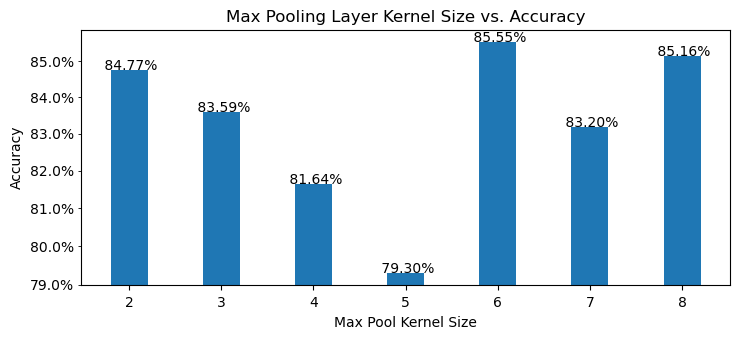

In [303]:
accuracies = [x[0] for x in sortedPairs]
pool_sizes = [x[1] for x in sortedPairs]

for i in range(numTrials):
    plt.annotate(f"{accuracies[i]*100: .2f}%", xy=(pool_sizes[i], accuracies[i]), xytext=(pool_sizes[i], accuracies[i]), ha='center')

plt.yscale("log")
ax = plt.subplot()
ax.yaxis.set_minor_formatter(ticker.PercentFormatter(xmax=1))

plt.title("Max Pooling Layer Kernel Size vs. Accuracy")
plt.xlabel('Max Pool Kernel Size')
plt.ylabel('Accuracy')
plt.bar(pool_size, accuracies, width=0.4)
plt.savefig('graphs/poolingSize.png')
plt.show()

### Experimenting with the pool stride

In [95]:
def build_model(hp):
  
  model = keras.Sequential()

  model.add(keras.layers.Conv2D(32, 3, activation="relu"))
  stride = hp.Int("Kernel Stride", min_value=1, max_value=5)
  poolSize = 6
  model.add(keras.layers.Conv2D(32, 3, activation="relu"))
  model.add(keras.layers.MaxPool2D(poolSize,stride))
  model.add(keras.layers.Conv2D(32, 3, activation="relu"))
  model.add(keras.layers.MaxPool2D(poolSize,stride))
  model.add(keras.layers.Conv2D(32, 3, activation="relu"))
  model.add(keras.layers.MaxPool2D(poolSize,stride))

  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(2, activation="softmax"))

  model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  return model

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [304]:

pool_stride_tuner = RandomSearch(
                    build_model, 
                    objective="val_accuracy",
                    max_trials=10,
                    directory='./convLayers',
                    project_name='poolingLayerTests-stride-tests')

In [101]:
pool_stride_tuner.search(train_images, train_labels, validation_data=(test_images, test_labels), epochs=10, batch_size=32, callbacks=[stop_early])

Trial 5 Complete [00h 00m 33s]
val_accuracy: 0.875

Best val_accuracy So Far: 0.8984375
Total elapsed time: 08h 28m 43s


In [305]:
print(pool_stride_tuner.results_summary())

Results summary
Results in ./convLayers/poolingLayerTests-stride-tests
Showing 10 best trials
Trial summary
Hyperparameters:
Kernel Stride: 5
Score: 0.8984375
Trial summary
Hyperparameters:
Kernel Stride: 4
Score: 0.890625
Trial summary
Hyperparameters:
Kernel Stride: 3
Score: 0.875
Trial summary
Hyperparameters:
Kernel Stride: 2
Score: 0.85546875
Trial summary
Hyperparameters:
Kernel Stride: 1
Score: 0.8125
None


#### Results Graph

In [306]:
numTrials = 5
params = pool_stride_tuner.get_best_hyperparameters(num_trials=numTrials) #get hyper params best to worst

scores = []
pool_stride = []
for i in range(numTrials):
    with open(f"./convLayers/poolingLayerTests-stride-tests/trial_{i:02d}/trial.json", 'r') as json_file:
        data = json.load(json_file)
        scores.append(data["score"])
    pool_stride.append(params[i]['Kernel Stride'])


scores = sorted(scores)
pool_stride = pool_stride[::-1] # reverse the order of the hyperparameters without sorting the list

sortedPairs = sorted(list(zip(scores, pool_stride)), key=lambda x: x[0])
print(sortedPairs)

[(0.8125, 1), (0.85546875, 2), (0.875, 3), (0.890625, 4), (0.8984375, 5)]


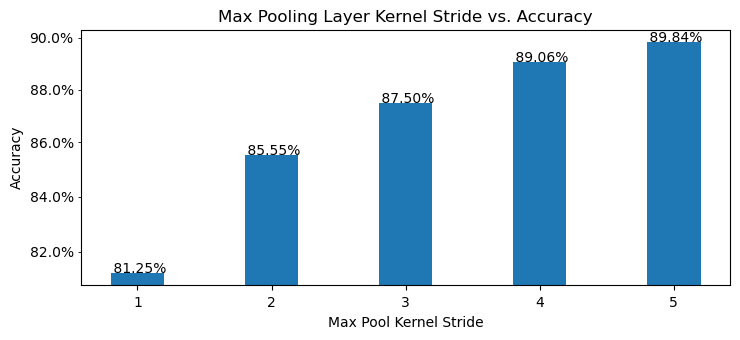

In [307]:
accuracies = [x[0] for x in sortedPairs]
pool_stride = [x[1] for x in sortedPairs]

for i in range(numTrials):
    plt.annotate(f"{accuracies[i]*100: .2f}%", xy=(pool_stride[i], accuracies[i]), xytext=(pool_stride[i], accuracies[i]), ha='center')

plt.yscale("log")
ax = plt.subplot()
ax.yaxis.set_minor_formatter(ticker.PercentFormatter(xmax=1))

plt.title("Max Pooling Layer Kernel Stride vs. Accuracy")
plt.xlabel('Max Pool Kernel Stride')
plt.ylabel('Accuracy')
plt.bar(pool_stride, accuracies, width=0.4)
plt.savefig('graphs/poolStride.png')
plt.show()


### Experimenting with additional Dense layers prior to the output layer

In [14]:
def build_model(hp):
  model = keras.Sequential()
  poolSize = 5
  stride = 4
  model.add(keras.layers.Conv2D(32, 3, activation="relu"))
  model.add(keras.layers.Conv2D(32, 3, activation="relu"))
  model.add(keras.layers.MaxPool2D(poolSize,stride))
  model.add(keras.layers.Conv2D(32, 3, activation="relu"))
  model.add(keras.layers.MaxPool2D(poolSize,stride))
  model.add(keras.layers.Conv2D(32, 3, activation="relu"))
  model.add(keras.layers.MaxPool2D(poolSize,stride))

  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(hp.Choice("Dense Layer Size", [2, 4, 8, 16, 32,64, 128, 256, 512, 1028]), activation="softmax"))
  model.add(keras.layers.Dense(2, activation="sigmoid"))

  model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  
  return model

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [15]:
dense_layer_tuner = RandomSearch(
                    build_model, 
                    objective="val_accuracy",
                    max_trials=10, 
                    directory='./convLayers',
                    project_name='dense_layer_tests')

INFO:tensorflow:Reloading Oracle from existing project ./convLayers/dense_layer_tests/oracle.json
INFO:tensorflow:Reloading Tuner from ./convLayers/dense_layer_tests/chief.json


In [115]:
dense_layer_tuner.search(train_images, train_labels, validation_data=(test_images, test_labels), epochs=10, batch_size=32, callbacks=[stop_early])

Trial 10 Complete [00h 01m 13s]
val_accuracy: 0.87890625

Best val_accuracy So Far: 0.91796875
Total elapsed time: 00h 09m 43s


In [16]:
dense_layer_tuner.results_summary()

Results summary
Results in ./convLayers/dense_layer_tests
Showing 10 best trials
Trial summary
Hyperparameters:
Dense Layer Size: 512
Score: 0.91796875
Trial summary
Hyperparameters:
Dense Layer Size: 4
Score: 0.91015625
Trial summary
Hyperparameters:
Dense Layer Size: 1028
Score: 0.89453125
Trial summary
Hyperparameters:
Dense Layer Size: 8
Score: 0.89453125
Trial summary
Hyperparameters:
Dense Layer Size: 2
Score: 0.890625
Trial summary
Hyperparameters:
Dense Layer Size: 64
Score: 0.890625
Trial summary
Hyperparameters:
Dense Layer Size: 16
Score: 0.88671875
Trial summary
Hyperparameters:
Dense Layer Size: 256
Score: 0.87890625
Trial summary
Hyperparameters:
Dense Layer Size: 32
Score: 0.875
Trial summary
Hyperparameters:
Dense Layer Size: 128
Score: 0.8671875


#### Results Graph

In [8]:
numTrials = 10
params = dense_layer_tuner.get_best_hyperparameters(num_trials=numTrials) #get hyper params best to worst

scores = []
dense_layer_size = []
for i in range(numTrials):
    with open(f"./convLayers/dense_layer_tests/trial_{i:02d}/trial.json", 'r') as json_file:
        data = json.load(json_file)
        scores.append(data["score"])
    dense_layer_size.append(params[i]['Dense Layer Size'])


scores = sorted(scores)
dense_layer_size = dense_layer_size[::-1] # reverse the order of the hyperparameters without sorting the list


sortedPairs = sorted(list(zip(scores, dense_layer_size)), key=lambda x: x[1])
print(sortedPairs)

[(0.890625, 2), (0.91015625, 4), (0.89453125, 8), (0.88671875, 16), (0.875, 32), (0.890625, 64), (0.8671875, 128), (0.87890625, 256), (0.91796875, 512), (0.89453125, 1028)]


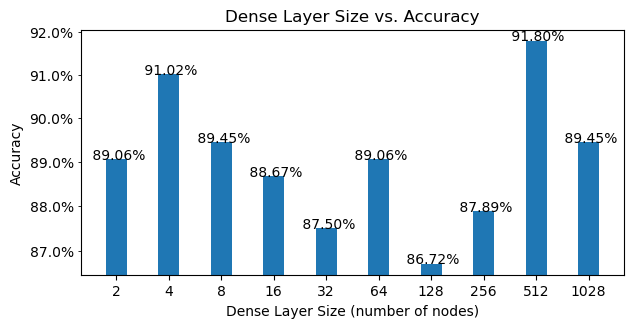

In [9]:
n = 10
a = np.arange(n)
# tuples = sorted(list(zip(accuracies, dense_layer_size, a)), key=lambda x: x[1])
accuracies = [x[0] for x in sortedPairs]
dense_layer_sizes = [x[1] for x in sortedPairs]

x = dense_layer_sizes
y = accuracies
# z  = [x[2] for x in tuples]

fig = plt.figure(1, figsize=(7,7))
ax  = fig.add_subplot(212)

for i in range(numTrials):
    ax.annotate(f"{accuracies[i]*100: .2f}%", xy=(a[i], accuracies[i]), xytext=(a[i], accuracies[i]), ha='center')

ax.bar(a, y, width=0.4) #we plot y as a function of a, which parametrizes x
plt.yscale("log")
ax.yaxis.set_minor_formatter(ticker.PercentFormatter(xmax=1))
ax.xaxis.set_ticks(a) #set the ticks to be a

ax.xaxis.set_ticklabels(x) # change the ticks' names to x
plt.title("Dense Layer Size vs. Accuracy")
plt.xlabel('Dense Layer Size (number of nodes)')
plt.ylabel('Accuracy')
plt.savefig('graphs/denseLayerSizes.png')
plt.show()

### Save the best Model

In [22]:
best_model = dense_layer_tuner.get_best_models()[0]
loss, accuracy = best_model.evaluate(test_images, test_labels)
print(f"Accuracy: {accuracy*100:.2f}% ")
# best_model.summary()

8/8 [==============================] - 1s 70ms/step - loss: 0.5421 - accuracy: 0.9180
Accuracy: 91.80% 


In [23]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (32, 298, 298, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (32, 296, 296, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (32, 73, 73, 32)         0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (32, 71, 71, 32)          9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 17, 17, 32)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (32, 15, 15, 32)          9

In [33]:
best_model.save_weights("./models/ckpt")
best_model.save("./models/best_model")

INFO:tensorflow:Assets written to: ./models/best_model/assets


INFO:tensorflow:Assets written to: ./models/best_model/assets
